In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from zipfile import ZipFile

dataset_train = "/kaggle/input/dogs-vs-cats/train.zip"
    
with ZipFile(dataset_train, 'r') as zip:
    zip.extractall()

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
# from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [21]:
from zipfile import ZipFile
dataset_train = "/kaggle/input/dogs-vs-cats/train.zip"
extracted_dir = "train"

with ZipFile(dataset_train, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Step 2: Prepare the DataFrame with filenames and categories
filenames = os.listdir(extracted_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df = df.sample(n=15000, random_state=42).reset_index(drop=True)


In [22]:
df.head()

,filename,category
0,cat.6689.jpg,0
1,dog.10379.jpg,1
2,dog.3355.jpg,1
3,cat.648.jpg,0
4,cat.9935.jpg,0


In [23]:
df.tail()

,filename,category
14995,dog.10406.jpg,1
14996,dog.11220.jpg,1
14997,cat.6028.jpg,0
14998,cat.2953.jpg,0
14999,dog.2942.jpg,1


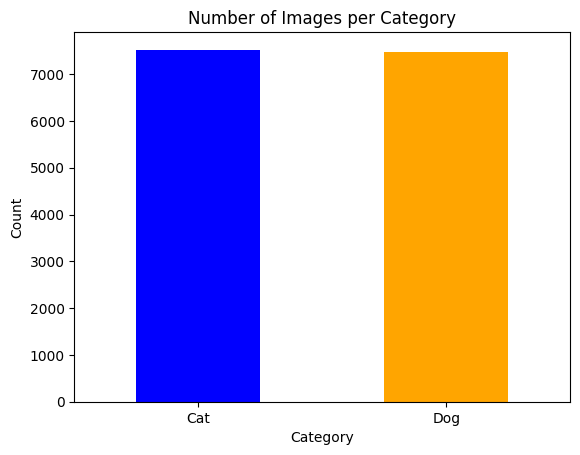

In [24]:
category_counts = df['category'].value_counts()
colors = ['blue', 'orange']

# plt.figure(figsize=(5, 4))
category_counts.plot(kind='bar', color=colors, rot=0)
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Cat', 'Dog'])
plt.show()



In [25]:
def load_images_from_df(df, base_dir, img_size=(128, 128)):
    data = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(base_dir, row['filename'])
        try:
            img_array = cv2.imread(img_path)
            img_array = cv2.resize(img_array, img_size)
            data.append(img_array)
            labels.append(row['category'])
        except Exception as e:
            pass
    return np.array(data), np.array(labels)

data, labels = load_images_from_df(df, extracted_dir)

# Normalize the pixel values
data = data / 255.0

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
data = preprocess_input(data)
features = vgg_model.predict(data)
features = features.reshape(features.shape[0], -1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step


In [31]:
pca = PCA(n_components=100) 
features_pca = pca.fit_transform(features)
from sklearn.metrics import accuracy_score, classification_report

# Train the SVM
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
svm = SVC(kernel='rbf', C=5, class_weight='balanced')
history=svm.fit(X_train, y_train)

# Evaluate the Model
y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6973333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      1525
           1       0.70      0.68      0.69      1475

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000

